In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
%matplotlib inline


dataset = 'Data/Little-River-SCAN-2008-2017.csv'
label_set = labels_set = 'Data/header_descriptions.csv'
labels = pd.read_csv(labels_set)
df = pd.read_csv(dataset)

In [213]:
df

,Site Id,Date,PREC.I-1 (in),TOBS.I-1 (degC),TMAX.D-1 (degC),TMIN.D-1 (degC),TAVG.D-1 (degC),SMS.I-1:-2 (pct) (loam),SMS.I-1:-4 (pct) (loam),SMS.I-1:-8 (pct) (loam),...,RDC.I-1:-2 (unit),RDC.I-1:-4 (unit),RDC.I-1:-8 (unit),RDC.I-1:-20 (unit),RDC.I-5:-40 (unit),BATT.I-1 (volt),BATT.I-2 (volt),WDIRV.D-1 (degr),WSPDV.D-1 (mph),PRCP
0,2027,2008-11-01,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,...,6.00,5.90,7.00,7.70,14.80,13.39,3.32,63.0,2.8,0.0
1,2027,2008-11-02,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,...,6.00,5.80,6.80,7.60,14.80,13.37,3.32,92.0,2.1,0.0
2,2027,2008-11-03,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,...,5.90,5.70,6.80,7.60,14.70,13.35,3.33,98.0,2.0,0.0
3,2027,2008-11-04,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,...,5.90,5.70,6.60,7.40,14.70,13.30,3.33,82.0,5.3,0.0
4,2027,2008-11-05,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,...,5.80,5.60,6.60,7.50,14.50,13.32,3.33,74.0,4.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,2027,2017-11-27,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,...,5.42,5.70,6.55,6.18,15.13,12.85,3.24,345.0,3.7,0.0
3137,2027,2017-11-28,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,...,5.26,5.62,6.78,5.99,15.29,12.87,3.22,75.0,1.8,0.0
3138,2027,2017-11-29,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,...,5.09,5.62,6.54,6.17,15.22,12.88,3.22,83.0,2.8,0.0
3139,2027,2017-11-30,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,...,5.20,5.52,6.29,6.01,15.01,12.87,3.24,54.0,2.3,0.0


In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Id                    3141 non-null   int64  
 1   Date                       3141 non-null   object 
 2   PREC.I-1 (in)              2980 non-null   float64
 3   TOBS.I-1 (degC)            3073 non-null   float64
 4   TMAX.D-1 (degC)            3065 non-null   float64
 5   TMIN.D-1 (degC)            3062 non-null   float64
 6   TAVG.D-1 (degC)            3062 non-null   float64
 7   SMS.I-1:-2 (pct)  (loam)   3070 non-null   float64
 8   SMS.I-1:-4 (pct)  (loam)   3074 non-null   float64
 9   SMS.I-1:-8 (pct)  (loam)   2536 non-null   float64
 10  SMS.I-1:-20 (pct)  (loam)  3071 non-null   float64
 11  SMS.I-5:-40 (pct)  (loam)  3072 non-null   float64
 12  STO.I-1:-2 (degC)          3074 non-null   float64
 13  STO.I-1:-4 (degC)          3074 non-null   float

In [215]:
# Split DateTime Col
def make_date_cols(dFrame) :
    date_splits = [
    ('year', 0 , 4), ('month', 5, 7), ('day', 8,10)
    ]
    for i in date_splits:
        dFrame[i[0]] = [d[i[1]:i[2]] for d in dFrame['Date']]
    return dFrame
df = make_date_cols(df)

In [216]:
df.year.value_counts().sort_values(ascending=True)

2008     54
2010    318
2017    327
2012    331
2014    340
2009    342
2011    353
2013    356
2016    359
2015    361
Name: year, dtype: int64

In [217]:
# Get how many duplicated days we have
def get_dup_subset(dFrame):
    return dFrame.loc[dFrame.duplicated(subset=['Date'], keep=False), :]
print(f'Duplicated Days: {get_dup_subset(df).shape[0]}')

Duplicated Days: 18


In [218]:
# Merge Duplicates
df = df.groupby('Date').mean().reset_index()
# Remove duplicates
df.drop_duplicates(subset=['Date'], inplace=True)
# Check our work
print(f'Duplicated Days: {get_dup_subset(df).shape[0]}')

Duplicated Days: 0


In [219]:
df = make_date_cols(df)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Site Id,PREC.I-1 (in),TOBS.I-1 (degC),TMAX.D-1 (degC),TMIN.D-1 (degC),TAVG.D-1 (degC),SMS.I-1:-2 (pct) (loam),SMS.I-1:-4 (pct) (loam),SMS.I-1:-8 (pct) (loam),...,RDC.I-1:-20 (unit),RDC.I-5:-40 (unit),BATT.I-1 (volt),BATT.I-2 (volt),WDIRV.D-1 (degr),WSPDV.D-1 (mph),PRCP,year,month,day
0,2008-11-01,2027.0,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,...,7.70,14.80,13.39,3.32,63.0,2.8,0.0,2008,11,01
1,2008-11-02,2027.0,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,...,7.60,14.80,13.37,3.32,92.0,2.1,0.0,2008,11,02
2,2008-11-03,2027.0,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,...,7.60,14.70,13.35,3.33,98.0,2.0,0.0,2008,11,03
3,2008-11-04,2027.0,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,...,7.40,14.70,13.30,3.33,82.0,5.3,0.0,2008,11,04
4,2008-11-05,2027.0,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,...,7.50,14.50,13.32,3.33,74.0,4.5,0.0,2008,11,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,2017-11-27,2027.0,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,...,6.18,15.13,12.85,3.24,345.0,3.7,0.0,2017,11,27
3128,2017-11-28,2027.0,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,...,5.99,15.29,12.87,3.22,75.0,1.8,0.0,2017,11,28
3129,2017-11-29,2027.0,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,...,6.17,15.22,12.88,3.22,83.0,2.8,0.0,2017,11,29
3130,2017-11-30,2027.0,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,...,6.01,15.01,12.87,3.24,54.0,2.3,0.0,2017,11,30


In [220]:
def custom_labeler(dFrame):
    labels.drop([0], inplace=True)
    colsMap = {}
    def labelGen(label):
        row = labels.loc[labels['Label'] == label, :].iloc[0]
        temp = f'{row.Element} {row["Sensor Height"]} ({row.Unit})'
        temp = temp.replace('nan', '')
        return temp.strip()
    cols_string = ",".join(dFrame.columns[1:-3])
    replacements = ['(degC)','(pct)','(loam)','(gram)','(unit)','(volt)', '(degr)','(in)','(mph)']
    for i in replacements:
        cols_string = cols_string.replace(i, '')

    cols_list = [i.strip() for i in cols_string.split(',')]

    zipped_cols = dict(zip(list(dFrame.columns[1:-3]), cols_list))

    for i in list(labels.Label):
        colsMap[i] = labelGen(i)


    return dFrame.rename(columns=zipped_cols).rename(columns=colsMap)


labeled_df = custom_labeler(df.copy())
labeled_df.set_index(['Date'], inplace=True)
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2008-11-01 to 2017-12-01
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site Id                                3132 non-null   float64
 1   Precipitation Accumulation  (In)       2972 non-null   float64
 2   Air Temperature Observed  (Degc)       3073 non-null   float64
 3   Air Temperature Maximum  (Degc)        3065 non-null   float64
 4   Air Temperature Minimum  (Degc)        3062 non-null   float64
 5   Air Temperature Average  (Degc)        3062 non-null   float64
 6   Soil Moisture Percent -2" (Pct)        3070 non-null   float64
 7   Soil Moisture Percent -4" (Pct)        3074 non-null   float64
 8   Soil Moisture Percent -8" (Pct)        2536 non-null   float64
 9   Soil Moisture Percent -20" (Pct)       3071 non-null   float64
 10  Soil Moisture Percent -40" (Pct)       3072 non-null  

<AxesSubplot:>

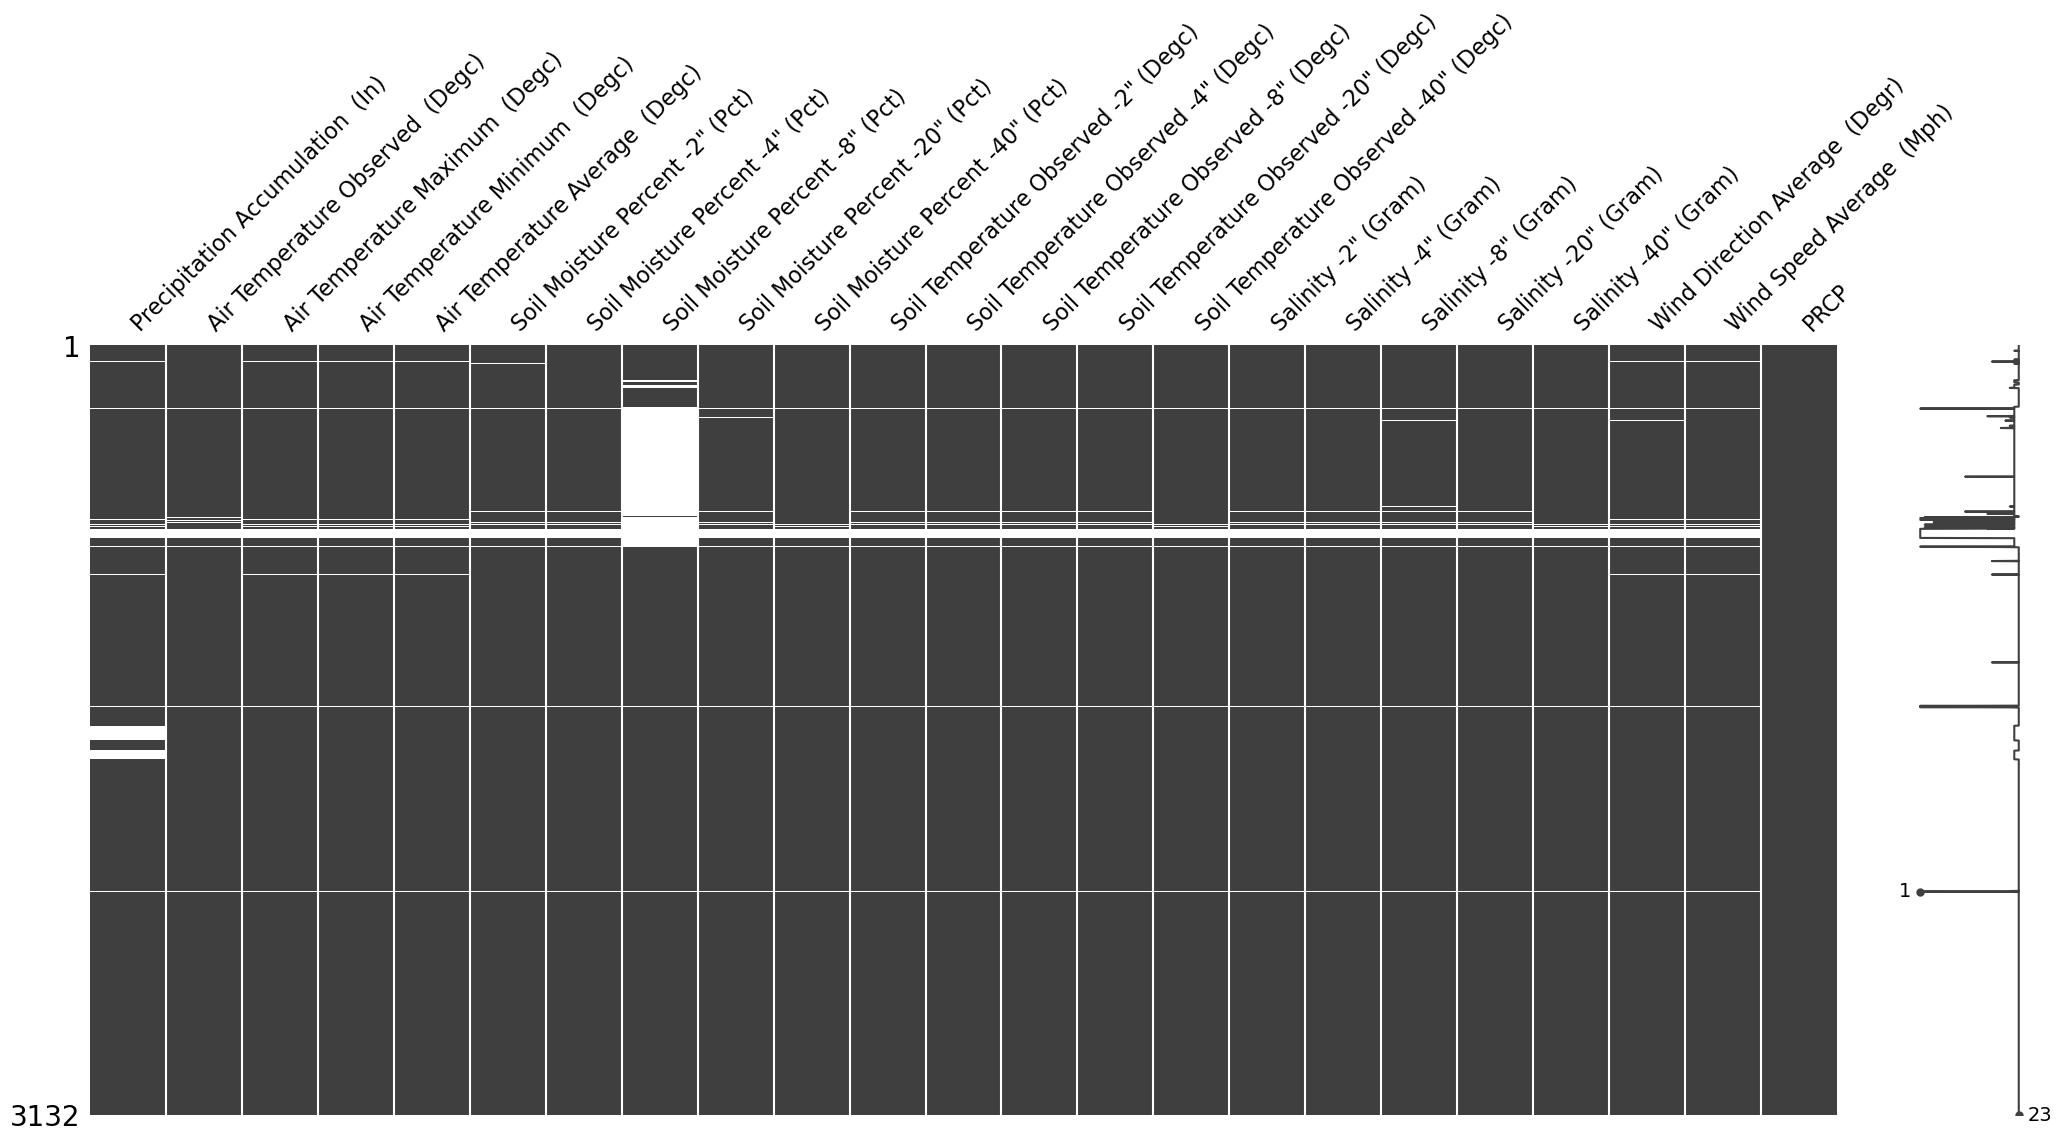

In [221]:
# We do neet to worry about Battery power of the SCAN system nor the site id let's drop those columns
labeled_df.drop(['Site Id', 'Battery  (Volt)', 'Battery  (Volt)','Real Dielectric Constant -2" (Unit)','Real Dielectric Constant -4" (Unit)','Real Dielectric Constant -8" (Unit)', 'Real Dielectric Constant -20" (Unit)','Real Dielectric Constant -40" (Unit)'], inplace=True, axis=1)
msno.matrix(labeled_df.drop(['year', 'day','month'], axis=1))

We are missing a good bit of data so lets think about how we are doing to handle this it looks like we have a large amount of data missing from all sensors so lets find what point in time that is occuring within

In [222]:
print('Total nans by Year')
for i in labeled_df.year.value_counts().index.sort_values():
    temp_df = labeled_df.loc[labeled_df['year'] == i, :].sort_index()
    print(f'{i} : {temp_df.isnull().sum().sum()}')

Total nans by Year
2008 : 1
2009 : 212
2010 : 415
2011 : 1123
2012 : 6
2013 : 192
2014 : 0
2015 : 27
2016 : 0
2017 : 0


<AxesSubplot:>

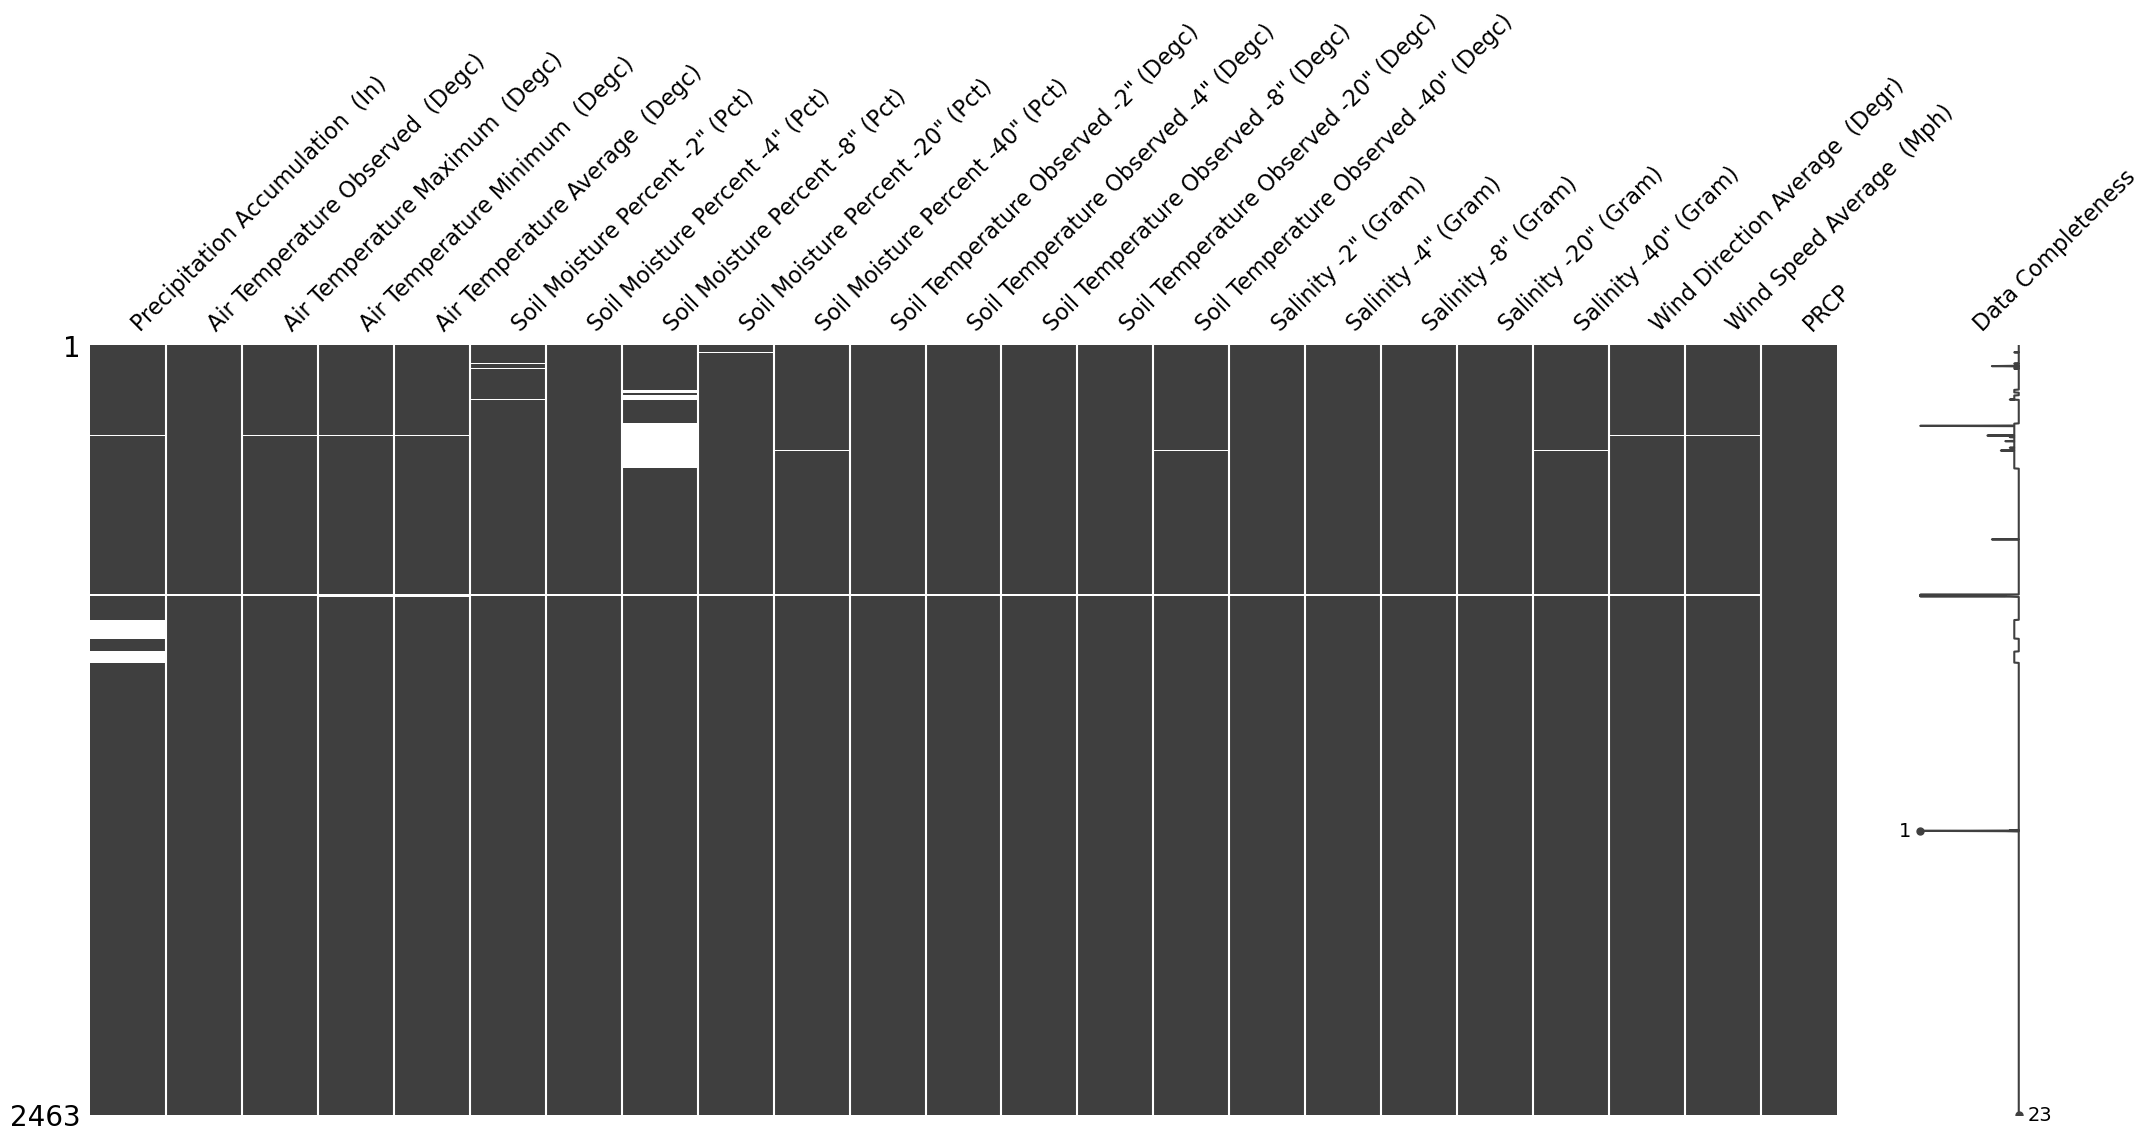

In [223]:
# From this we see that years 2011 and 2021 are pretty useless due to their large amount of missing values i.e. NAN > 800
labeled_df = labeled_df[labeled_df.year !=  '2011']
labeled_df = labeled_df[labeled_df.year !=  '2010']
msno.matrix(labeled_df.drop(['day','year','month'], axis=1), labels=True)

So it seems that we are missing a large portion of soil moisture percentage at 8" we can use KNN imputing to resolve this missing data lets begin imputing to deal with our nans

In [224]:
from sklearn.impute import KNNImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

X = labeled_df.copy().drop(['year', 'day', 'month'], axis=1)
# Get rid of negative values
X = X.mask(X < 0)
# Create the Pipe
pipe = Pipeline([('KNN Imputation',KNNImputer(n_neighbors=6))])
# Harness Pipeline
X_imputed = pipe.fit_transform(X)

# Make df from imputed data
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

X_imputed_df

,Precipitation Accumulation (In),Air Temperature Observed (Degc),Air Temperature Maximum (Degc),Air Temperature Minimum (Degc),Air Temperature Average (Degc),"Soil Moisture Percent -2"" (Pct)","Soil Moisture Percent -4"" (Pct)","Soil Moisture Percent -8"" (Pct)","Soil Moisture Percent -20"" (Pct)","Soil Moisture Percent -40"" (Pct)",...,"Soil Temperature Observed -20"" (Degc)","Soil Temperature Observed -40"" (Degc)","Salinity -2"" (Gram)","Salinity -4"" (Gram)","Salinity -8"" (Gram)","Salinity -20"" (Gram)","Salinity -40"" (Gram)",Wind Direction Average (Degr),Wind Speed Average (Mph),PRCP
0,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,12.3,24.0,...,17.0,20.0,0.1,0.1,0.1,0.1,0.1,63.0,2.8,0.0
1,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,12.2,24.1,...,16.9,19.8,0.1,0.1,0.1,0.1,0.1,92.0,2.1,0.0
2,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,12.2,23.9,...,17.1,19.6,0.0,0.0,0.1,0.1,0.1,98.0,2.0,0.0
3,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,11.7,23.9,...,17.7,19.6,0.0,0.0,0.1,0.1,0.1,82.0,5.3,0.0
4,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,11.9,23.7,...,17.9,19.6,0.0,0.0,0.1,0.1,0.1,74.0,4.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,9.2,24.5,...,15.4,14.8,0.1,0.1,0.1,0.1,0.2,345.0,3.7,0.0
2459,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,8.8,24.7,...,14.9,14.7,0.1,0.1,0.1,0.1,0.1,75.0,1.8,0.0
2460,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,9.2,24.6,...,15.1,14.5,0.1,0.1,0.1,0.1,0.1,83.0,2.8,0.0
2461,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,8.8,24.3,...,15.8,14.5,0.1,0.1,0.1,0.1,0.2,54.0,2.3,0.0


In [225]:
# Plot the now imputed Data
X_imputed_df.rename(columns={'PRCP' : 'Daily Percipitation (mm)'}, inplace = True)
X_imputed_df

,Precipitation Accumulation (In),Air Temperature Observed (Degc),Air Temperature Maximum (Degc),Air Temperature Minimum (Degc),Air Temperature Average (Degc),"Soil Moisture Percent -2"" (Pct)","Soil Moisture Percent -4"" (Pct)","Soil Moisture Percent -8"" (Pct)","Soil Moisture Percent -20"" (Pct)","Soil Moisture Percent -40"" (Pct)",...,"Soil Temperature Observed -20"" (Degc)","Soil Temperature Observed -40"" (Degc)","Salinity -2"" (Gram)","Salinity -4"" (Gram)","Salinity -8"" (Gram)","Salinity -20"" (Gram)","Salinity -40"" (Gram)",Wind Direction Average (Degr),Wind Speed Average (Mph),Daily Percipitation (mm)
0,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,12.3,24.0,...,17.0,20.0,0.1,0.1,0.1,0.1,0.1,63.0,2.8,0.0
1,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,12.2,24.1,...,16.9,19.8,0.1,0.1,0.1,0.1,0.1,92.0,2.1,0.0
2,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,12.2,23.9,...,17.1,19.6,0.0,0.0,0.1,0.1,0.1,98.0,2.0,0.0
3,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,11.7,23.9,...,17.7,19.6,0.0,0.0,0.1,0.1,0.1,82.0,5.3,0.0
4,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,11.9,23.7,...,17.9,19.6,0.0,0.0,0.1,0.1,0.1,74.0,4.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,9.2,24.5,...,15.4,14.8,0.1,0.1,0.1,0.1,0.2,345.0,3.7,0.0
2459,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,8.8,24.7,...,14.9,14.7,0.1,0.1,0.1,0.1,0.1,75.0,1.8,0.0
2460,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,9.2,24.6,...,15.1,14.5,0.1,0.1,0.1,0.1,0.1,83.0,2.8,0.0
2461,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,8.8,24.3,...,15.8,14.5,0.1,0.1,0.1,0.1,0.2,54.0,2.3,0.0


Text(0.5, 1.0, 'Daily Percipitation (mm)')

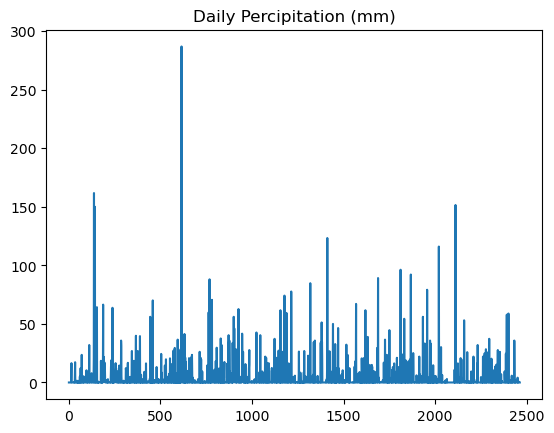

In [226]:
X_imputed_df['Daily Percipitation (mm)'] = X_imputed_df['Daily Percipitation (mm)'].apply(lambda x: round(x, 4))
plt.plot(X_imputed_df['Daily Percipitation (mm)'])
plt.title('Daily Percipitation (mm)')

In [227]:
X_imputed_df['Daily Percipitation (mm)'].describe()

count    2463.000000
mean        3.816890
std        12.995579
min         0.000000
25%         0.000000
50%         0.000000
75%         0.800000
max       287.000000
Name: Daily Percipitation (mm), dtype: float64

Create SPI Gamma/Threshold

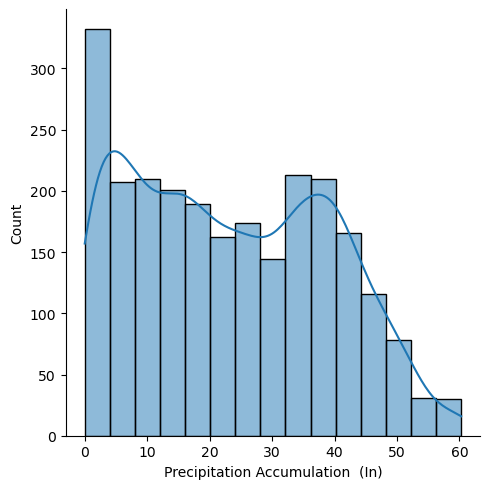

In [243]:
from scipy import stats
# Dual Subplot

#Left Plot

sns.displot(X_imputed_df['Precipitation Accumulation  (In)'], kde=True)



/var/folders/b9/vxww42z578b0bb9jx8l2m_1c0000gn/T/ipykernel_78640/48279658.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_imputed_df['Precipitation Accumulation  (In)'],


<AxesSubplot:xlabel='Precipitation Accumulation  (In)', ylabel='Density'>

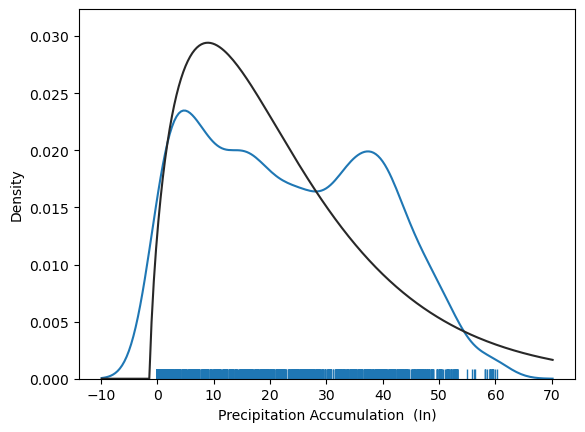

In [238]:
sns.distplot(X_imputed_df['Precipitation Accumulation  (In)'],
             hist=False,
             kde=True,
             rug=True,
             fit=stats.gamma,
             fit_kws=dict(label='gamma'),
             kde_kws=dict(label='kde'))